## Benchmark: `to_tensor` versus `to_quimb_tensor`

We start by implementing a class `CircuitGenerator` that generates a ZX circuit in the form of a graph. There are two main methods that we use: the first is to simply call the method `CNOT_HAD_PHASE_circuit` from PyZX library, and the other generates multiple layers, each one consisting of CZ gates and two Z spiders on the first line with random phases. The latter has the effect of producing dense graphs.

In [1]:
import sys; sys.path.append('..')
import matplotlib.pyplot as plt
import quimb.tensor as qtn
import cotengra as ctg
import quimb as qu
import numpy as np
import pyzx as zx
import time, random

class CircuitGenerator:
    def __init__(self, dense: bool = False, depth: int = 10, qubits: int = 5):
        self.__dense = dense
        self.__depth = depth
        self.__qubits = qubits
    
    def __call__(self) -> zx.Graph:
        g = self.__dense_graph(self.__depth)
        assert g is not None
        return self.__dense_graph(self.__depth) if self.__dense \
                                                else zx.generate.CNOT_HAD_PHASE_circuit(qubits = self.__qubits,
                                                                                        depth = self.__depth,
                                                                                        clifford = False).to_graph()
        
    def __dense_graph(self, layers_count: int = 10) -> zx.Graph:
        g = zx.Graph()
        inputs = [g.add_vertex(zx.VertexType.BOUNDARY, row = 0) for _ in range(5)]
        outputs = [g.add_vertex(zx.VertexType.BOUNDARY, row = 3 * layers_count + 1) for _ in range(5)]

        # This local function adds a new layer having a particular shape;
        # we need the previous five nodes along each line, together with the
        # index cnt of the layer we need to construct.
        # It returns the new last vertex on each line.
        def add_layer(prev, cnt):
            # Rows on which the new eight vertices in a zig-zag shape are ideally placed.
            rows_for_layer = [3 * cnt + i for i in [1, 1, 2, 2, 1, 1, 2, 2]]
            # Create the vertices.
            layer = [g.add_vertex(zx.VertexType.Z, row = rows_for_layer[i]) for i in range(8)]
            # Construct the edges between these eight vertices in a zis-zag shape.
            H, S = zx.EdgeType.HADAMARD, zx.EdgeType.SIMPLE
            tupes = [(0, 1, H), (2, 3, H), (4, 5, H), (6, 7, H), (1, 2, S), (3, 4, S), (5, 6, S)]
            for i, j, edgetype in tupes:
                g.add_edge(g.edge(layer[i], layer[j]), edgetype)

            # We collect the first (front) and the last (end) vertex on each of the five lines.
            front_indices = [0, 1, 4, 5, 7]
            end_indices = [0, 2, 3, 6, 7]
            # Connect the previous layer (or the inputs if this is to be the first one)
            # to the current layer.
            for i in range(5):
                g.add_edge(g.edge(prev[i], layer[front_indices[i]]), zx.EdgeType.SIMPLE)

            # Add two randomised vertices on the first line;
            # Their phases are k * pi / 4 and l * pi / 4, where k and l are independent
            # and unformly distributed over {0, 1, ..., 7}.
            [k, l] = [g.add_vertex(zx.VertexType.Z,
                                   phase = (random.randrange(8)) / 4.,
                                   row = 3 * cnt + i + 2) for i in range(2)]
            g.add_edge(g.edge(layer[end_indices[0]], k), edgetype = zx.EdgeType.SIMPLE)
            g.add_edge(g.edge(k, l), edgetype = zx.EdgeType.SIMPLE)

            # Collect the last vertices along each line; on the first line this is l;
            # on the other lines, they are those corresponding to indices [1..5) in end_indices.
            end_vertices = [l]
            end_vertices.extend([layer[i] for i in end_indices[1:]])
            return end_vertices

        # Add all layers whilst updating the prev vertices.
        prev = inputs
        for cnt in range(layers_count):
            prev = add_layer(prev, cnt)

        # Connect the prev vertices with the outputs.
        for i in range(5):
            g.add_edge(g.edge(prev[i], outputs[i]), zx.EdgeType.SIMPLE)
        
        # Normalize the graph so as to recognize the inputs and outputs
        g.normalize()
        return g

Now we implement a class `CircuitBenchmark` which performs time profiling of `to_tensor` and `to_quimb_tensor`:
* The constructor sets up fields `n` for the number of circuits to be averaged in one go and `full_reduce` which specifies whether the function with the same name from `PyZX` ought to be used before converting the diagrams to circuits.
* A private method `run_tensor` is used to generate a circuit, convert it to a graph, use kets 0 as inputs and bras 0 as outputs and calculate the required times for this diagram.
* Another private method `run_tensors` which simply calls `run_tensor` multiple times and returns the average times.
* A public method `run_with_qubits` which takes a range as input and uses it to change the number of qubits in each iteration; returns two lists containing the times for obtaining the normal and quimb tensor networks, respectively.
* A public method `run_with_depths` which is the same as before but now the number of qubits is fixed and the the depth varies.
* A public method `display_plot` which plots tensor and quimb times.
* A static method `get_tabel` which returns a string that tabulates tensor and quimb times.* A public method `display_tabel_and_plot` which both tabulates and plots the same data.

In [2]:
class CircuitBenchmark():
    def __init__(self, n: int, dense: bool = False, full_reduce: bool = False):
        self.__n = n
        self.__dense = dense
        self.__full_reduce = full_reduce
    
    def run_with_qubits(self, depth, qubits_range):
        tensor_times = []
        quimb_times = []
        self.__depth = depth
        for qubits in qubits_range:
            self.__qubits = qubits
            self.__generator = CircuitGenerator(self.__dense, depth, qubits)
            tensor_time, quimb_time = self.__run_tensors()
            tensor_times.append(tensor_time)
            quimb_times.append(quimb_time)
        return tensor_times, quimb_times

    def run_with_depths(self, qubits, depth_range):
        tensor_times = []
        quimb_times = []
        self.__qubits = qubits
        for depth in depth_range:
            self.__depth = depth
            self.__generator = CircuitGenerator(self.__dense, depth, qubits)
            tensor_time, quimb_time = self.__run_tensors()
            tensor_times.append(tensor_time)
            quimb_times.append(quimb_time)
        return tensor_times, quimb_times
    
    def __run_tensor(self):
        # Generate a circuit and convert it to a graph object
        g = self.__generator()
        if self.__full_reduce:
            zx.full_reduce(g)
        g.apply_state("0" * self.__qubits)  # use kets 0 as inputs
        g.apply_effect("0" * self.__qubits) # use bras 0 as outputs
        zx.to_gh(g)                         # get rid of red spiders

        # Profiling to_tensor
        t = time.time()
        tensor = g.to_tensor()
        tensor_time = time.time() - t
        
        # Profiling to_quimb_tensor
        t = time.time()
        quimb_tn = zx.to_quimb_tensor(g).contract(output_inds = ())
        quimb_time = time.time() - t
        
        # Assert correctness and update the list fields.
        assert abs(quimb_tn - tensor) < 1e-9, "to_tensor and to_quimb_tensor don't exhibit the same result"
        self.__tensor_times.append(tensor_time)
        self.__quimb_times.append(quimb_time)
    
    def __run_tensors(self):
        self.__tensor_times = []
        self.__quimb_times = []
        for _ in range(self.__n):
            self.__run_tensor()
        return (np.mean(self.__tensor_times), np.mean(self.__quimb_times))
    
    def display_plot(self, tensor_times, quimb_times, range, has_qubits: bool):
        this_type, other_type, quantity = ("qubits", "depth", self.__depth) if has_qubits else \
                                          ("depth", "qubits", self.__qubits)
        fig, ax = plt.subplots()
        ax.plot(range, tensor_times, label = "to_tensor")
        ax.plot(range, quimb_times, label = "to_quimb_tensor")
        ax.set_xlabel(this_type)
        ax.set_ylabel("time (s)")
        ax.set_title("From {} to {} {}, fixed {} of {}".format(range[0], range[-1], this_type, other_type, quantity))
        ax.legend()
    
    @staticmethod
    def get_table(var, range_var, tensor_times, quimb_times):
        def list_to_row(name, elems):
            s = name.ljust(15)
            is_first = True
            for x in elems:
                if is_first:
                    is_first = False
                else:
                    s += " | "
                s += str(x).rjust(7) if isinstance(x, int) else "{:.3f}".format(x).rjust(7)
            return s
        
        s = list_to_row(f"{var}:", range_var)
        s += '\n'
        s += list_to_row("Tensor times:", tensor_times)
        s += '\n'
        s += list_to_row("Quimb times:", quimb_times)
        s += '\n'
        return s
    
    def display_tabel_and_plot(self, tensor_times, quimb_times, range, has_qubits: bool):
        this_type, other_type, quantity = ("Qubits", "depth", self.__depth) if has_qubits else \
                                          ("Depth", "qubits", self.__qubits)
        str_full_reduce = " (with full_reduce = True)" if self.__full_reduce else ""
        print("For {} {}{}:\n".format(quantity, other_type, str_full_reduce))
        print(CircuitBenchmark.get_table(this_type, range, tensor_times, quimb_times))
        self.display_plot(tensor_times, quimb_times, range, has_qubits)

We now compare `to_tensor` against `to_quimb_tensor` by fixing the depth and varying the number of qubits, while `full_reduce` is, by default, `False`:

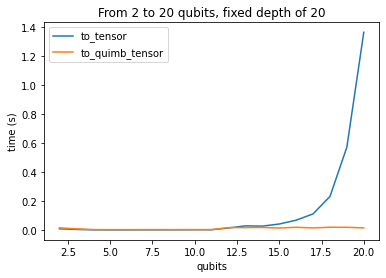

In [20]:
depth = 20
qubits_range = range(2, 21)
cb = CircuitBenchmark(3)
tensor_times, quimb_times = cb.run_with_qubits(depth, qubits_range)
cb.display_plot(tensor_times, quimb_times, qubits_range, has_qubits = True)

The time for transforming the circuit into a normal tensor network and contracting it takes time that increases exponentially with the number of qubits when the depth is fixed, whereas the time for building and contracting the corresponding Quimb tensor network remains (roughly) constant.

Now we fix the number of qubits and change the depth:

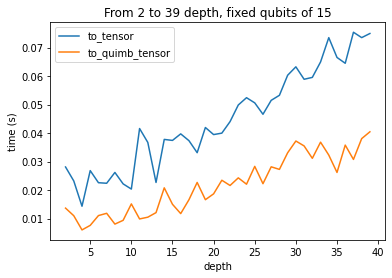

In [21]:
qubits = 15
depth_range = range(2, 40)
tensor_times, quimb_times = cb.run_with_depths(qubits, depth_range)
cb.display_plot(tensor_times, quimb_times, depth_range, has_qubits = False)

Interestingly, as the depth increases and the number of qubits is fixed, both tasks seem to perform the same up to a constant factor; the curves are roughly linear. Quimb definitely has the better constant.

Now we repeat the same experiments but with `full_reduce = True`:

For 20 depth (with full_reduce = True):

Qubits:              2 |       3 |       4 |       5 |       6 |       7 |       8 |       9 |      10 |      11 |      12 |      13 |      14 |      15
Tensor times:    0.003 |   0.002 |   0.004 |   0.008 |   0.008 |   0.017 |   0.039 |   0.013 |   0.019 |   0.038 |   0.046 |   0.319 |   0.122 |   0.882
Quimb times:     0.004 |   0.004 |   0.006 |   0.012 |   0.010 |   0.010 |   0.011 |   0.013 |   0.013 |   0.013 |   0.012 |   0.016 |   0.013 |   0.013



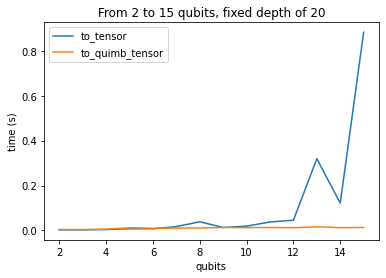

In [5]:
cb = CircuitBenchmark(n = 5, full_reduce = True)
qubits_range = range(2, 16)
tensor_times, quimb_times = cb.run_with_qubits(depth, qubits_range)
cb.display_tabel_and_plot(tensor_times, quimb_times, qubits_range, has_qubits = True)

When the depth is fixed, there are certain situations when the normal method is better, but overall Quimb is better because, as the the number of qubits gets higher, not only it firmly outperforms, but some circuits take exponentially more time to be contracted with `to_tensor`.

For 15 qubits (with full_reduce = True):

Depth:               2 |       3 |       4 |       5 |       6 |       7 |       8 |       9 |      10 |      11 |      12 |      13 |      14 |      15 |      16 |      17 |      18 |      19 |      20 |      21 |      22
Tensor times:    0.015 |   0.016 |   0.013 |   0.017 |   0.022 |   0.018 |   0.021 |   0.047 |   0.074 |   0.050 |   0.094 |   0.031 |   0.052 |   0.079 |   0.090 |   0.096 |   0.120 |   0.604 |   0.244 |   0.711 |   0.409
Quimb times:     0.008 |   0.005 |   0.007 |   0.007 |   0.007 |   0.009 |   0.008 |   0.007 |   0.010 |   0.008 |   0.015 |   0.008 |   0.013 |   0.012 |   0.016 |   0.014 |   0.012 |   0.014 |   0.014 |   0.011 |   0.011



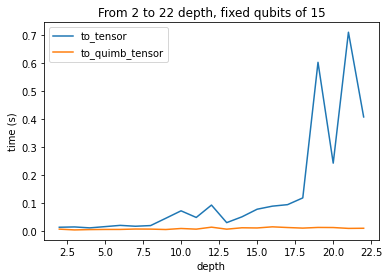

In [6]:
depth_range = range(2, 23)
tensor_times, quimb_times = cb.run_with_depths(qubits, depth_range)
cb.display_tabel_and_plot(tensor_times, quimb_times, depth_range, has_qubits = False)

As with `full_reduce = False`, we got two functions that grow almost the same at the beginning, up to a constant factor, with Quimb having the (much) better constant; then `to_tensor` time increases exponentially.

Now we do some experiments with dense graphs:

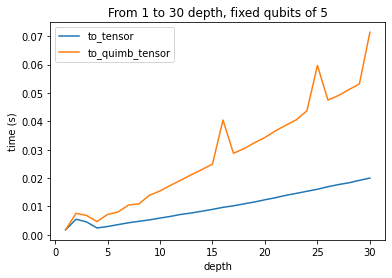

In [7]:
cb = CircuitBenchmark(n = 5, dense = True)
qubits = 5
depth_range = range(1, 31)
tensor_times, quimb_times = cb.run_with_depths(qubits, depth_range)
cb.display_plot(tensor_times, quimb_times, depth_range, has_qubits = False)

Both curves increase linearly but, perhaps surprisingly, `to_tensor` has the better constant.

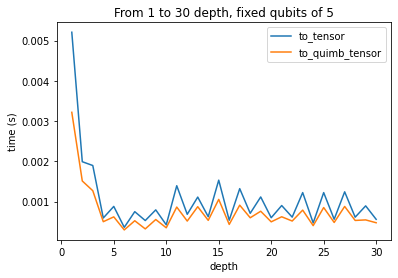

In [25]:
cb = CircuitBenchmark(n = 5, dense = True, full_reduce = True)
qubits = 5
depth_range = range(1, 31)
tensor_times, quimb_times = cb.run_with_depths(qubits, depth_range)
cb.display_plot(tensor_times, quimb_times, depth_range, has_qubits = False)

When `full_reduce` comes into play, the resulting times are negligible, as expected.

### Comparing different contraction path finder strategies
Now we will look at different contraction strategies that Quimb can use when performing the contraction. It is very important to note that finding the contraction path and actually performing the contraction are done separately and there is a performance trade off between them.

We employ some Hyper optimizers, namely **Greedy** (an agglomerative approach), **Betweenness** (community detection) and **KaHyPar** (a divisive approach, i.e. building the contraction tree from the top down), as per [this](https://quantum-journal.org/papers/q-2021-03-15-410/) paper.

The class `QuimbStrategies` that we use for this benchmark is very similar to the one above, having methods with the same labels.

In [3]:
class QuimbStrategies:
    def __init__(self, n: int, strategies, dense: bool = False, full_reduce: bool = False):
        self.__n = n
        self.__strategies = strategies
        self.__dense = dense
        self.__full_reduce = full_reduce
    
    def run_with_qubits(self, depth, qubits_range):
        times = [[] for _ in range(1 + len(self.__strategies))]
        self.__depth = depth
        
        for qubits in qubits_range:
            self.__qubits = qubits
            self.__generator = CircuitGenerator(self.__dense, depth, qubits)
            methods_times = self.__run_tensors()
            for i, time in enumerate(methods_times):
                times[i].append(time)
        return times
    
    def run_with_depth(self, qubits, depth_range):
        times = [[] for _ in range(1 + len(self.__strategies))]
        self.__qubits = qubits
        
        for depth in depth_range:
            self.__depth = depth
            self.__generator = CircuitGenerator(self.__dense, depth, qubits)
            methods_times = self.__run_tensors()
            for i, time in enumerate(methods_times):
                times[i].append(time)
        return times
    
    def __run_tensor(self):
        g = self.__generator()
        if self.__full_reduce:
            zx.full_reduce(g)
        g.apply_state("0" * self.__qubits)
        g.apply_effect("0" * self.__qubits)
        zx.to_gh(g)
        
        t = time.time()
        tensor = zx.to_quimb_tensor(g).contract(output_inds = ())
        self.__times[0].append(time.time() - t)
        
        for i, method in enumerate(self.__strategies):
            t = time.time()
            tn = zx.to_quimb_tensor(g)
            tn.full_simplify_('ADCRS', output_inds = (), equalize_norms = True)
            tn.contract(optimize = method, output_inds = ())
            self.__times[i + 1].append(time.time() - t)
    
    def __run_tensors(self):
        self.__times = [[] for _ in range(1 + len(self.__strategies))]
        for _ in range(self.__n):
            self.__run_tensor()
        return [np.mean(collection_of_times) for collection_of_times in self.__times]
    
    def display_plot(self, times, range, has_qubits: bool):
        this_type, other_type, quantity = ("qubits", "depth", self.__depth) if has_qubits else \
                                          ("depth", "qubits", self.__qubits)
        fig, ax = plt.subplots()
        for i, method_times in enumerate(times):
            ax.plot(range, method_times, '--', label = "basic" if i == 0 else self.__strategies[i - 1])
        ax.set_xlabel(this_type)
        ax.set_ylabel("time (s)")
        ax.set_title("From {} to {} {}, fixed {} of {}".format(range[0], range[-1], this_type, other_type, quantity))
        ax.legend()

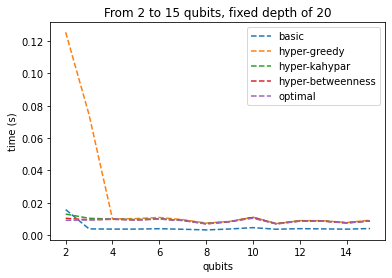

In [9]:
qs = QuimbStrategies(1, ["hyper-greedy", "hyper-kahypar", "hyper-betweenness", "optimal"])
qs.display_plot(qs.run_with_qubits(depth, qubits_range), qubits_range, has_qubits = True)

We conclude that the hyper optimizers perform well and almost the same when the number of qubits varies, but are worse than the basic greedy path optimizer that Quimb employs because of the time needed to find the paths.

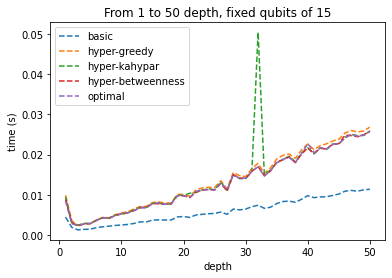

In [22]:
qs = QuimbStrategies(3, ["hyper-greedy", "hyper-kahypar", "hyper-betweenness", "optimal"])
qubits = 15
depth_range = range(1, 51)
qs.display_plot(qs.run_with_depth(qubits, depth_range), depth_range, has_qubits = False)

When the depth varies and the number of qubits is fixed, the same behaviour can be observed as when comparing `to_tensor` against `to_quimb_tensor`. The graphs increase linearly; the slope for the custom methods are (almost) identical and worse the the one for the basic optimizer. Ocasional spikes occur for all methods.

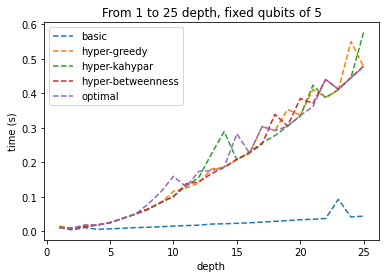

In [23]:
qs = QuimbStrategies(2, ["hyper-greedy", "hyper-kahypar", "hyper-betweenness", "optimal"], dense = True)
depth_range = range(1, 26)
qs.display_plot(qs.run_with_depth(5, depth_range), depth_range, has_qubits = False)

A rather striking fact can be observed when dense circuits are used without `full_reduce`: the custom optimisers perform poorly on dense circuits, i.e. time increases exponentially with the depth, whilst the basic one is able to mantain a linear increase with respect to the depth.

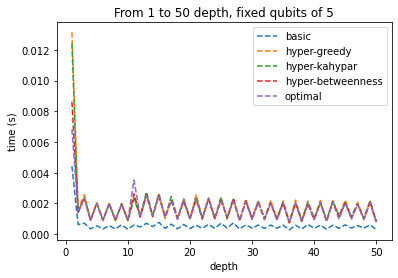

In [8]:
qs = QuimbStrategies(2, 
                     ["hyper-greedy", "hyper-kahypar", "hyper-betweenness", "optimal"], 
                     dense = True, 
                     full_reduce = True)
depth_range = range(1, 51)
qs.display_plot(qs.run_with_depth(5, depth_range), depth_range, has_qubits = False)

This, however, changes when performing `full_reduce` before transforming the diagram into a tensor network. All methods perform roughly the same when the depth (the number of layers in this case) is large enough (at least 5). This was to be expected because, when performing `full_reduce` on our dense graphs, they become sparse and so the basic approach performs better by not having to search for multiple paths and choosing the best one like the other approaches do. Nevertheless, the difference in time as well as the total time for each method is negligible.